### Manage the directories

In [1]:
# Input data files are available in the read-only "../input/" directory
# Running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/homework2/original_data/y_train.npy
/kaggle/input/homework2/original_data/x_train.npy


In [2]:
# To delete a folder
import shutil
if os.path.exists("/kaggle/working/nicholas"):
    shutil.rmtree("/kaggle/working/nicholas")

# to remove a file
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")
    
# to create a folder
import os
directory = "lstmCNN"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Preliminary operations

In [3]:
# Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### load data

In [5]:
x_train = np.load('/kaggle/input/homework2/original_data/x_train.npy')
y_train = np.load('/kaggle/input/homework2/original_data/y_train.npy')
x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [6]:
label_mapping = {
    "Wish",
    "Another",
    "Comfortably",
    "Money",
    "Breathe",
    "Time",
    "Brain",
    "Echoes",
    "Wearing",
    "Sorrow",
    "Hey",
    "Shine"
}

### Preprocessing
#### Scaling after splitting

In [7]:
#interpolation of data
from scipy.interpolate import interp1d

interpoFactor = 1

x_axis = np.linspace(0, 36, num=36, endpoint=True)
interpolate = interp1d(x_axis, x_train, kind='cubic', axis=1)
x_new = np.linspace(0, 36, num=(36*interpoFactor), endpoint=True)
x_train = interpolate(x_new)
x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [8]:
# Split train-val
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

# Scaling
train_data = np.concatenate([x for x in X_train]) 
scaler = StandardScaler().fit(train_data)

X_train_trans = [] 
for el in X_train: 
  X_train_trans.append(scaler.transform(el))
del X_train 

X_val_trans = [] 
for el in X_val: 
  X_val_trans.append(scaler.transform(el))
del X_val 

# all set
X_train = np.asarray(X_train_trans) 
X_val = np.asarray(X_val_trans) 

In [9]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

In [10]:
# print some scaler values
scaler.mean_
scaler.var_
scaler.scale_
scaler.n_features_in_
scaler.n_samples_seen_
scaler.with_mean
scaler.with_std
scaler.copy

True

## MODEL

In [11]:
def build_lstmCNN(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #layer
    reshape = tfkl.Reshape((interpoFactor, 36, 6), input_shape=((36*interpoFactor),6))(input_layer)
    
    convlstm = tfkl.ConvLSTM1D(512, 3)(reshape)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(convlstm)
    
    gap = tfkl.GlobalMaxPooling1D()(cnn)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.L1L2(l1=1e-4, l2=1e-3))(gap)
    classifier = tfkl.Dense(256, activation='relu')(classifier)

    output_layer = tfkl.Dense(12, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [12]:
input_shape = X_train.shape[1:] # 36,6
batch_size = 128
epochs = 150

In [13]:
model = build_lstmCNN(input_shape)
model.summary()

2022-12-16 23:57:04.657764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 23:57:04.811626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 23:57:04.812456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 23:57:04.813740: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 36, 6)          0         
_________________________________________________________________
conv_lst_m1d (ConvLSTM1D)    (None, 34, 512)           3184640   
_________________________________________________________________
conv1d (Conv1D)              (None, 34, 256)           393472    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792 

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150


2022-12-16 23:57:08.448903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-16 23:57:11.927377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16/16 [==============================] - 10s 66ms/step - loss: 2.8938 - accuracy: 0.3330 - val_loss: 2.5584 - val_accuracy: 0.3560
Epoch 2/150
16/16 [==============================] - 1s 35ms/step - loss: 2.3868 - accuracy: 0.3726 - val_loss: 2.2153 - val_accuracy: 0.3868
Epoch 3/150
16/16 [==============================] - 1s 35ms/step - loss: 2.0949 - accuracy: 0.4231 - val_loss: 2.0107 - val_accuracy: 0.4300
Epoch 4/150
16/16 [==============================] - 1s 35ms/step - loss: 1.9299 - accuracy: 0.4570 - val_loss: 1.9004 - val_accuracy: 0.4630
Epoch 5/150
16/16 [==============================] - 1s 37ms/step - loss: 1.8080 - accuracy: 0.4838 - val_loss: 1.8062 - val_accuracy: 0.4691
Epoch 6/150
16/16 [==============================] - 1s 36ms/step - loss: 1.6844 - accuracy: 0.5106 - val_loss: 1.6647 - val_accuracy: 0.5247
Epoch 7/150
16/16 [==============================] - 1s 35ms/step - loss: 1.6226 - accuracy: 0.5317 - val_loss: 1.6753 - val_accuracy: 0.5021
Epoch 8/150
16/16

### Select the best model

In [15]:
best_score = max(history['accuracy'])
best_score_val = max(history['val_accuracy'])

print("Max train accuracy obtained with this model:", best_score)
print("Max val accuracy obtained with this model:", best_score_val)

Max train accuracy obtained with this model: 0.7756047248840332
Max val accuracy obtained with this model: 0.7037037014961243


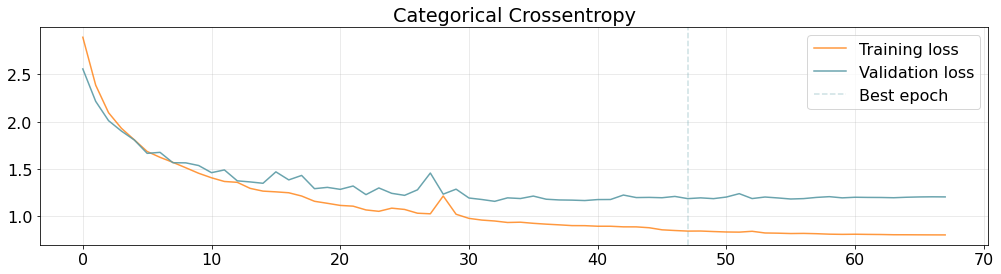

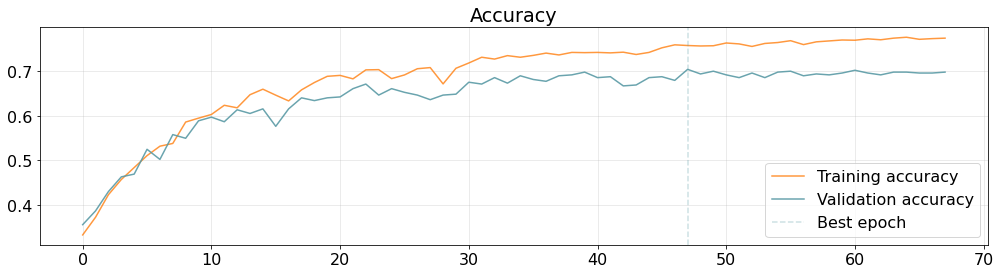

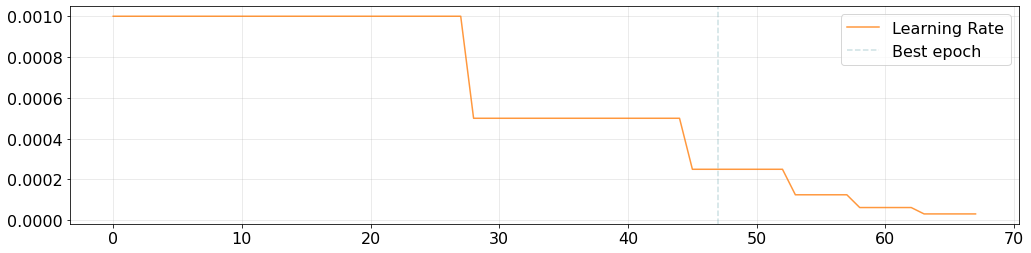

In [16]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### save model

In [17]:
model.save('lstmCNN')

2022-12-16 23:58:34.992540: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### confusion matrix

In [18]:
# Predict the test set with the LSTM
predictions = model.predict(X_val)
predictions.shape

(486, 12)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7037
Precision: 0.6346
Recall: 0.5833
F1: 0.5957


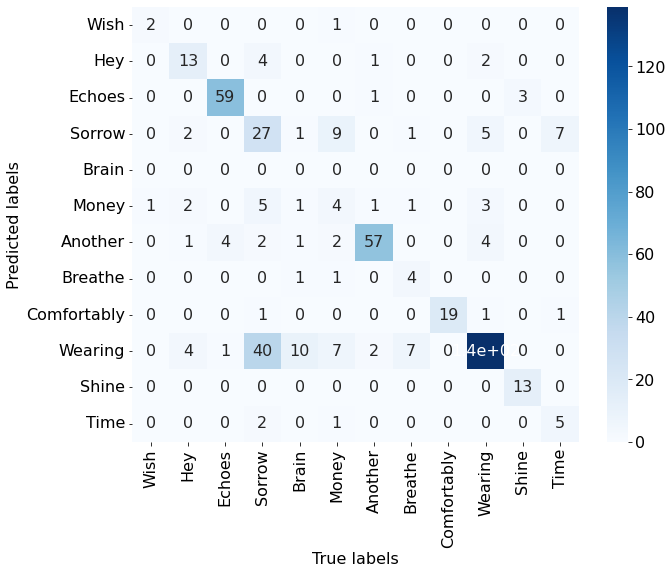

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping), yticklabels=list(label_mapping), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [20]:
import shutil
shutil.make_archive("out_lstmCNN", 'zip', "/kaggle/working/lstmCNN")

'/kaggle/working/out_lstmCNN.zip'